In [3]:
import numpy as np
from typing import Tuple, Optional
from math import copysign
import time
import pandas as pd
import matplotlib.pyplot as plt

def is_symmetric(A: np.ndarray, tol: float = 1e-12) -> bool:
    return np.allclose(A, A.T, atol=tol)

def offdiag_abs_sum(A: np.ndarray) -> float:
    return np.sum(np.abs(np.tril(A, k=-1)))

def householder_tridiagonal(A: np.ndarray) -> np.ndarray:
    A = A.copy().astype(float)
    n = A.shape[0]
    for k in range(n - 2):
        x = A[k+1:, k]
        normx = np.linalg.norm(x)
        if normx == 0.0: continue
        v = x.copy()
        v[0] += copysign(normx, x[0])
        v_norm = np.linalg.norm(v)
        if v_norm == 0.0: continue
        v /= v_norm
        Av = v @ A[k+1:, k:]
        A[k+1:, k:] -= 2.0 * np.outer(v, Av)
        Av2 = A[:, k+1:] @ v
        A[:, k+1:] -= 2.0 * np.outer(Av2, v)
        A = 0.5 * (A + A.T)
    return A

def householder_qr(M: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    A = M.copy().astype(float)
    n = A.shape[0]
    Q = np.eye(n)
    for k in range(n):
        x = A[k:, k]
        normx = np.linalg.norm(x)
        if normx == 0.0: continue
        v = x.copy()
        v[0] += copysign(normx, x[0])
        v_norm = np.linalg.norm(v)
        if v_norm == 0.0: continue
        v /= v_norm
        A_k = A[k:, k:]
        vTA = v @ A_k
        A[k:, k:] = A_k - 2.0 * np.outer(v, vTA)
        Q_k = Q[:, k:]
        Q[:, k:] = Q_k - 2.0 * np.outer(Q_k @ v, v)
    R = A
    return Q, R

def qr_eigenvalues(
    A: np.ndarray,
    max_iter: int = 500,
    tol: Optional[float] = None,
    return_iters_used: bool = False,
):
    assert A.shape[0] == A.shape[1], "Matrix must be square"
    if not is_symmetric(A):
        raise ValueError("Input matrix must be real symmetric")
    H = householder_tridiagonal(A)
    Ak = H.copy()
    iters = 0
    for it in range(max_iter):
        Q, R = householder_qr(Ak)
        Ak = R @ Q
        iters = it + 1
        if tol is not None and np.sum(np.abs(np.tril(Ak, k=-1))) < tol:
            break
    eigs = np.diag(Ak).copy()
    eigs.sort()
    eigs = eigs[::-1]
    return (eigs, iters if return_iters_used else None)

def eigenvalues_fixed_iterations(A: np.ndarray, k: int = 500) -> np.ndarray:
    evs, _ = qr_eigenvalues(A, max_iter=k, tol=None, return_iters_used=False)
    return evs

def eigenvalues_until_epsilon(A: np.ndarray, eps: float, max_iter: int = 5000):
    evs, iters = qr_eigenvalues(A, max_iter=max_iter, tol=eps, return_iters_used=True)
    return evs, iters

In [4]:
# Small example test of functions

A = np.array([[4., 1., 1.],
              [1., 9., 0.],
              [1., 0., 2.]])

vals_fixed = eigenvalues_fixed_iterations(A, k=500)
vals_eps, iters_eps = eigenvalues_until_epsilon(A, eps=1e-10, max_iter=5000)

# Reference (for checking only; not part of the algorithm):
vals_ref = np.linalg.eigvalsh(A)[::-1]

print("Fixed-500 eigvals:          ", vals_fixed)
print("Epsilon-stop eigvals:       ", vals_eps,  "(iters:", iters_eps, ")")
print("NumPy reference eigvals:    ", vals_ref)

print("Inf-norm error (fixed):   ", np.linalg.norm(np.sort(vals_fixed)-np.sort(vals_ref), ord=np.inf))
print("Inf-norm error (epsilon): ", np.linalg.norm(np.sort(vals_eps)  -np.sort(vals_ref),  ord=np.inf))

Fixed-500 eigvals:           [9.19767753 4.23706074 1.56526172]
Epsilon-stop eigvals:        [9.19767753 4.23706074 1.56526172] (iters: 34 )
NumPy reference eigvals:     [9.19767753 4.23706074 1.56526172]
Inf-norm error (fixed):    2.3092638912203256e-14
Inf-norm error (epsilon):  2.3092638912203256e-14


In [5]:
# --- Random generator for reproducibility ---
rng = np.random.default_rng(2025)

# --- Function to make one symmetric matrix of given type ---
def make_group_matrix(n: int, group: str) -> np.ndarray:
    """
    Generates an n×n symmetric matrix for a given group:
      'float'          -> random floats (standard normal)
      'int'            -> random integers in [-50, 50]
      'int_100_1000'   -> random integers in [100, 1000]
    """
    if group == "float":
        A = rng.standard_normal((n, n))
    elif group == "int":
        A = rng.integers(-50, 51, size=(n, n)).astype(float)
    elif group == "int_100_1000":
        A = rng.integers(100, 1001, size=(n, n)).astype(float)
    else:
        raise ValueError("Unknown group name")
    
    # Make symmetric: A = (A + A_T) / 2
    return 0.5 * (A + A.T)

# --- Define 3 groups and matrix sizes ---
groups = ["float", "int", "int_100_1000"]
#sizes = [120, 150, 180, 210, 240]
#reps = 2
sizes = [120, 150, 180]   # 5 different sizes (all >100)
reps = 1                             # 2 repetitions per size → 10 matrices per group

# --- Generate and store all 30 matrices ---
matrices = {}
for g in groups:
    for n in sizes:
        for rep in range(reps):
            key = f"{g}__n{n}__rep{rep}"
            matrices[key] = make_group_matrix(n, g)

print(f"Generated {len(matrices)} symmetric matrices:")
for k in list(matrices.keys())[:5]:
    print(" ", k, matrices[k].shape)

# --- Save to a single compressed file ---
np.savez_compressed("symmetric_matrices_2025.npz", **matrices)
print("\nSaved all matrices to 'symmetric_matrices_2025.npz'")

Generated 30 symmetric matrices:
  float__n120__rep0 (120, 120)
  float__n120__rep1 (120, 120)
  float__n150__rep0 (150, 150)
  float__n150__rep1 (150, 150)
  float__n180__rep0 (180, 180)

Saved all matrices to 'symmetric_matrices_2025.npz'


Loaded matrices: 30
Running test for float__n120__rep0 ...
Running test for float__n120__rep1 ...
Running test for float__n150__rep0 ...
Running test for float__n150__rep1 ...
Running test for float__n180__rep0 ...
Running test for float__n180__rep1 ...
Running test for float__n210__rep0 ...
Running test for float__n210__rep1 ...
Running test for float__n240__rep0 ...
Running test for float__n240__rep1 ...
Running test for int__n120__rep0 ...
Running test for int__n120__rep1 ...
Running test for int__n150__rep0 ...
Running test for int__n150__rep1 ...
Running test for int__n180__rep0 ...
Running test for int__n180__rep1 ...
Running test for int__n210__rep0 ...
Running test for int__n210__rep1 ...
Running test for int__n240__rep0 ...
Running test for int__n240__rep1 ...
Running test for int_100_1000__n120__rep0 ...
Running test for int_100_1000__n120__rep1 ...
Running test for int_100_1000__n150__rep0 ...
Running test for int_100_1000__n150__rep1 ...
Running test for int_100_1000__n180_

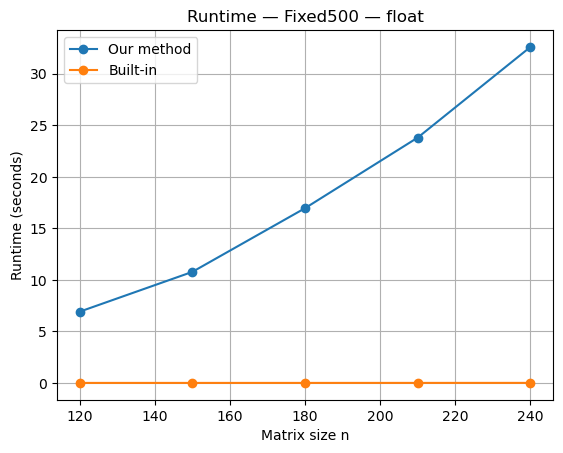

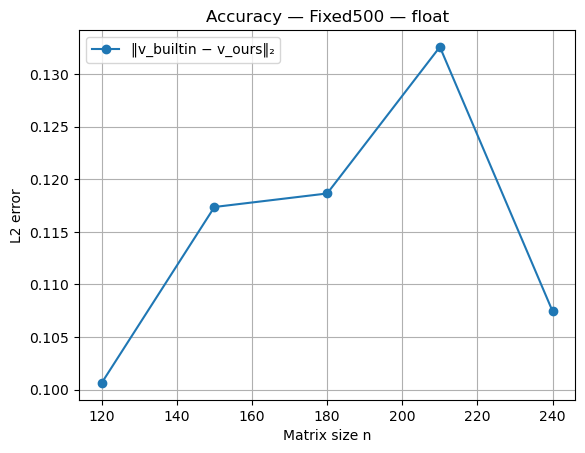

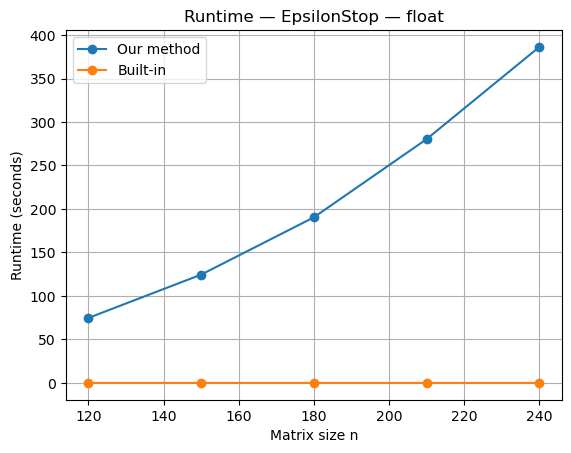

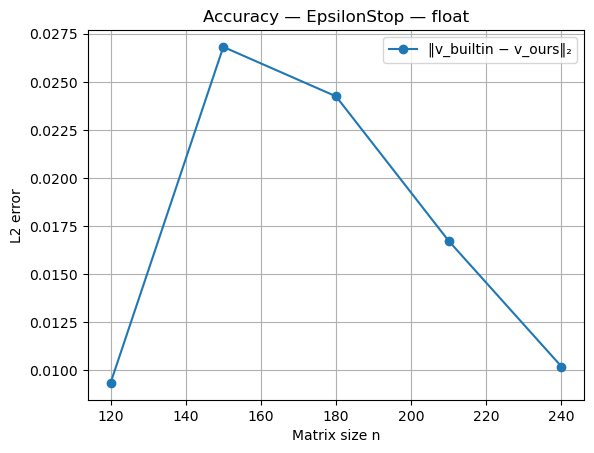

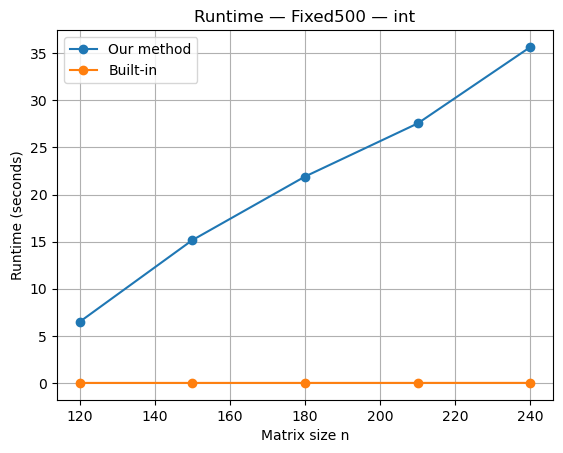

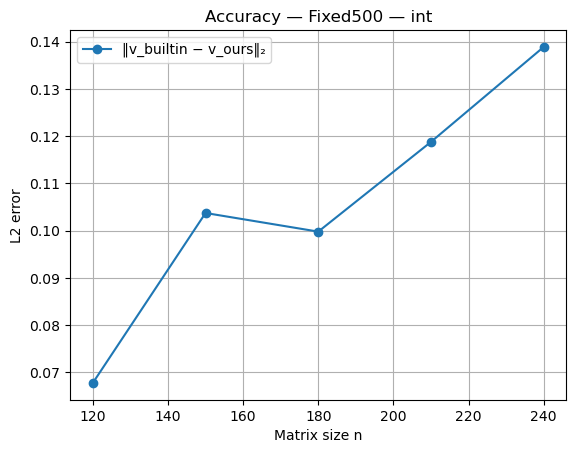

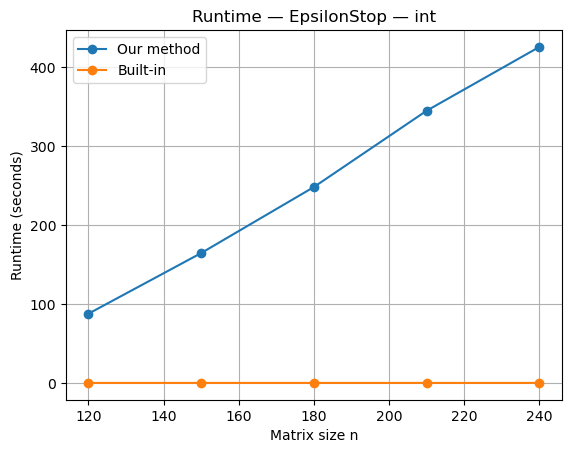

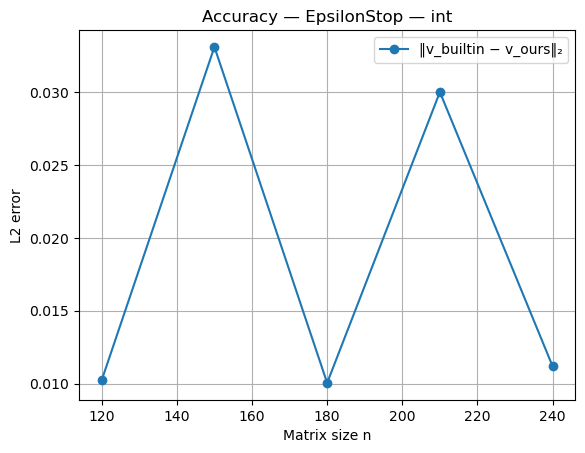

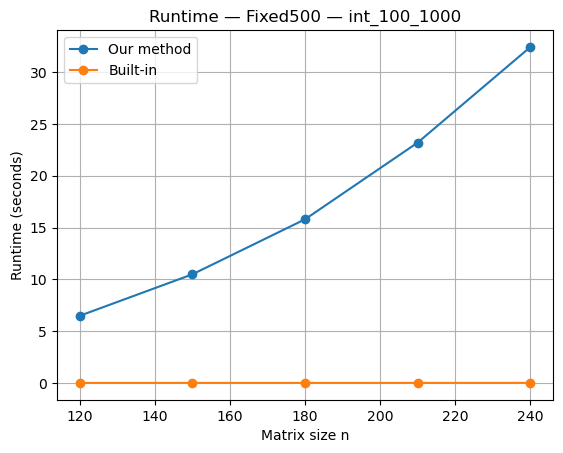

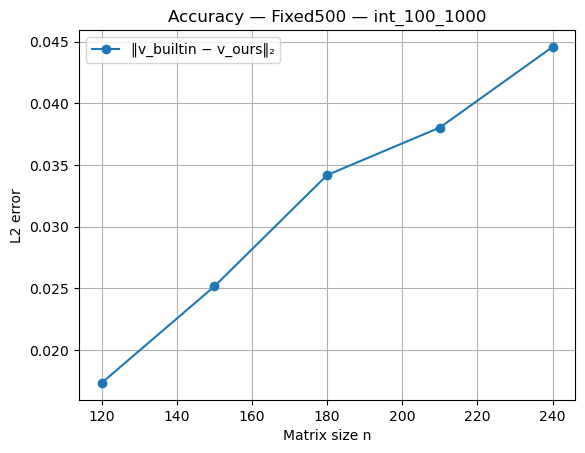

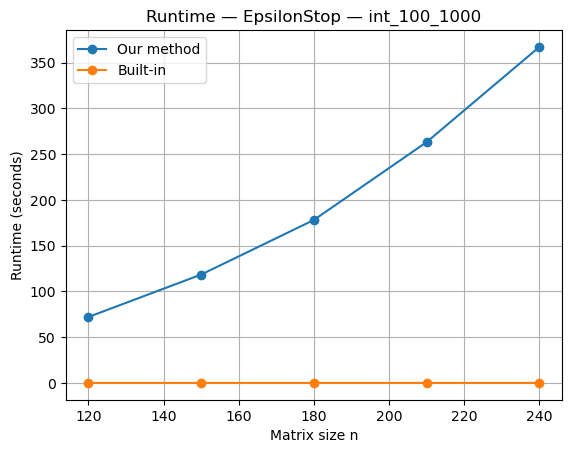

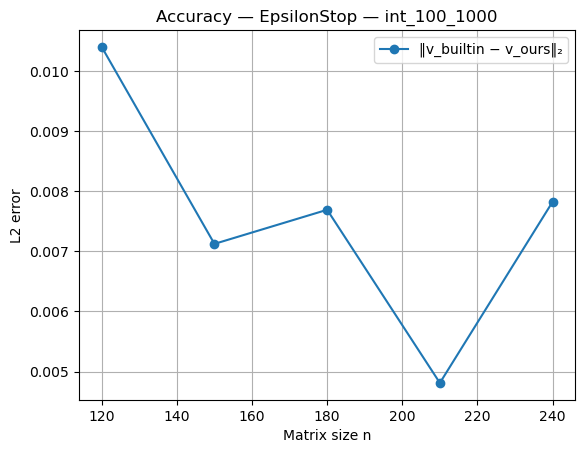

In [6]:
# 1. --- Load 30 symmetric matrices ---
data = np.load("symmetric_matrices_2025.npz")
print("Loaded matrices:", len(data.files))

# 2. --- Helper for accuracy norm ---
def accuracy_norm(v_builtin, v_ours):
    v1 = np.sort(v_builtin)
    v2 = np.sort(v_ours)
    num = np.linalg.norm(v1 - v2, ord=2)
    den = np.linalg.norm(v1, ord=2)
    return float(num / den)

# 3. --- Loop over all matrices, compare runtimes & accuracy ---
records_fixed = []
records_eps = []

for key in data.files:
    A = data[key]
    group, n_part, rep_part = key.split("__")
    n = int(n_part[1:])
    rep = int(rep_part[3:])
    print(f"Running test for {key} ...")

    # Built-in baseline
    t0 = time.perf_counter()
    v_builtin = np.linalg.eigvalsh(A)[::-1]  # descending
    t1 = time.perf_counter()

    # Fixed 500 iterations
    t2 = time.perf_counter()
    v_fixed = eigenvalues_fixed_iterations(A, k=500)
    t3 = time.perf_counter()

    # Epsilon stopping
    t4 = time.perf_counter()
    v_eps, iters_eps = eigenvalues_until_epsilon(A, eps=1e-10, max_iter=5000)
    t5 = time.perf_counter()

    records_fixed.append({
        "group": group, "n": n, "rep": rep,
        "rt_builtin": t1 - t0, "rt_ours": t3 - t2,
        "acc_l2": accuracy_norm(v_builtin, v_fixed)
    })
    records_eps.append({
        "group": group, "n": n, "rep": rep,
        "rt_builtin": t1 - t0, "rt_ours": t5 - t4,
        "acc_l2": accuracy_norm(v_builtin, v_eps),
        "iters_eps": iters_eps
    })

print("Finished all 30 matrices.")

# 4. --- Convert to DataFrames ---
df_fixed = pd.DataFrame(records_fixed)
df_eps = pd.DataFrame(records_eps)

# Average results per group and size
agg_fixed = df_fixed.groupby(["group", "n"], as_index=False).mean(numeric_only=True)
agg_eps = df_eps.groupby(["group", "n"], as_index=False).mean(numeric_only=True)

agg_fixed.to_csv("results_fixed.csv", index=False)
agg_eps.to_csv("results_eps.csv", index=False)
print("Saved: results_fixed.csv, results_eps.csv")

# 5. --- Plot runtime + accuracy figures ---
def plot_runtime(df, group, title):
    df_g = df[df["group"]==group].sort_values("n")
    plt.figure()
    plt.plot(df_g["n"], df_g["rt_ours"], marker="o", label="Our method")
    plt.plot(df_g["n"], df_g["rt_builtin"], marker="o", label="Built-in")
    plt.xlabel("Matrix size n")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"Runtime — {title} — {group}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"runtime_{title}_{group}.png", dpi=150, bbox_inches="tight")

def plot_accuracy(df, group, title):
    df_g = df[df["group"]==group].sort_values("n")
    plt.figure()
    plt.plot(df_g["n"], df_g["acc_l2"], marker="o", label="‖v_builtin − v_ours‖₂")
    plt.xlabel("Matrix size n")
    plt.ylabel("L2 error")
    plt.title(f"Accuracy — {title} — {group}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"accuracy_{title}_{group}.png", dpi=150, bbox_inches="tight")

for g in ["float", "int", "int_100_1000"]:
    plot_runtime(agg_fixed, g, "Fixed500")
    plot_accuracy(agg_fixed, g, "Fixed500")
    plot_runtime(agg_eps, g, "EpsilonStop")
    plot_accuracy(agg_eps, g, "EpsilonStop")

print("Saved 12 figures: runtime_* and accuracy_* .png")

# Few example results
print("\nAverage runtimes and accuracy (Fixed 500):")
print(agg_fixed)
print("\nAverage runtimes and accuracy (Epsilon stop):")
print(agg_eps)

In [ ]:
# NONSYMMETRIC MATRICES

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ---- Helpers for NONSYMMETRIC matrices (NO symmetry check, NO tridiagonalization) ----
def qr_nonsym_fixed(A: np.ndarray, max_iter: int = 500):
    """
    Unshifted QR on a general (possibly nonsymmetric) matrix using your own householder_qr().
    Returns the diagonal of Ak after max_iter steps (note: for nonsymmetric A, this is NOT guaranteed to be the eigenvalues).
    """
    Ak = A.astype(float).copy()
    for _ in range(max_iter):
        Q, R = householder_qr(Ak)
        Ak = R @ Q
    return np.diag(Ak)

def qr_nonsym_eps(A: np.ndarray, eps: float = 1e-10, max_iter: int = 5000):
    """
    Unshifted QR with epsilon stopping on a general matrix.
    Returns (diag(Ak), iterations_used).
    """
    Ak = A.astype(float).copy()
    iters = 0
    for it in range(max_iter):
        Q, R = householder_qr(Ak)
        Ak = R @ Q
        iters = it + 1
        if offdiag_abs_sum(Ak) < eps:
            break
    return np.diag(Ak), iters

# ---- Configuration per the assignment ----
rng = np.random.default_rng(42)
sizes = [120, 160, 200, 240]   # 4 sizes > 100
num_trials = 10                # 10 nonsymmetric matrices per size

# ---- Storage for trial-level data ----
rows = []

print("Running nonsymmetric bonus experiments…")
for n in sizes:
    for trial in range(1, num_trials + 1):
        A = rng.normal(size=(n, n))   # NONSYMMETRIC on purpose

        # Built-in reference (supports complex eigenvalues)
        t0 = time.perf_counter()
        lam_builtin = np.linalg.eigvals(A)
        t_builtin = time.perf_counter() - t0

        # QR — Fixed 500
        t0 = time.perf_counter()
        lam_fixed = qr_nonsym_fixed(A, max_iter=500)
        t_fixed = time.perf_counter() - t0

        # QR — Epsilon stop
        t0 = time.perf_counter()
        lam_eps, iters_eps = qr_nonsym_eps(A, eps=1e-10, max_iter=5000)
        t_eps = time.perf_counter() - t0

        # Accuracy vs built-in
        err_fixed = np.linalg.norm(
            np.sort_complex(lam_fixed.astype(complex)) - np.sort_complex(lam_builtin)
        )
        err_eps = np.linalg.norm(
            np.sort_complex(lam_eps.astype(complex)) - np.sort_complex(lam_builtin)
        )

        frac_complex = float(np.mean(np.abs(np.imag(lam_builtin)) > 1e-12))

        rows.append(dict(
            n=n, trial=trial,
            t_builtin=t_builtin, t_fixed=t_fixed, t_eps=t_eps,
            err_fixed=err_fixed, err_eps=err_eps,
            iters_eps=iters_eps, frac_complex=frac_complex
        ))
    print(f"  n={n}: completed {num_trials} trials.")

# ---- DataFrames ----
df_trials = pd.DataFrame(rows)
agg = (df_trials.groupby("n", as_index=False)
       .agg(t_builtin_mean=("t_builtin","mean"),
            t_fixed_mean=("t_fixed","mean"),
            t_eps_mean=("t_eps","mean"),
            err_fixed_mean=("err_fixed","mean"),
            err_eps_mean=("err_eps","mean"),
            iters_eps_mean=("iters_eps","mean"),
            frac_complex_mean=("frac_complex","mean")))

# ---- Save CSV artifacts ----
out_dir = Path("nonsymmetric_results")
out_dir.mkdir(exist_ok=True)
df_trials.to_csv(out_dir / "nonsymmetric_trials.csv", index=False)
agg.to_csv(out_dir / "nonsymmetric_summary.csv", index=False)

print("\nSummary (means over 10 trials per size):")
print(agg.to_string(index=False))

# ---- Plot: Runtime vs size ----
plt.figure(figsize=(7,5))
plt.plot(agg["n"], agg["t_builtin_mean"], 'o-', label='Built-in (eigvals)')
plt.plot(agg["n"], agg["t_fixed_mean"],   'o-', label='Our QR — Fixed 500')
plt.plot(agg["n"], agg["t_eps_mean"],     'o-', label='Our QR — Epsilon stop')
plt.xlabel("Matrix size n")
plt.ylabel("Runtime [s]")
plt.title("Runtime — Nonsymmetric matrices")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("runtime_nonsymmetric.png", dpi=150)
plt.show()

# ---- Plot: Accuracy vs size (L2 of eigenvalue lists) ----
plt.figure(figsize=(7,5))
plt.plot(agg["n"], agg["err_fixed_mean"], 'o-', label='L2 error — Fixed 500')
plt.plot(agg["n"], agg["err_eps_mean"],   'o-', label='L2 error — Epsilon stop')
plt.xlabel("Matrix size n")
plt.ylabel("L₂ difference |λ_builtin − λ_ours|")
plt.title("Accuracy — Nonsymmetric matrices")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("accuracy_nonsymmetric.png", dpi=150)
plt.show()

print("\nSaved files:")
print("  - runtime_nonsymmetric.png")
print("  - accuracy_nonsymmetric.png")
print("  - nonsymmetric_results/nonsymmetric_trials.csv")
print("  - nonsymmetric_results/nonsymmetric_summary.csv")

Running nonsymmetric bonus experiments…
  n=120: completed 10 trials.
